In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
eps = 0.3

In [4]:
random_noise = np.random.normal(
    loc   = 0,      # 平均
    scale = 1,      # 標準偏差
    size  = (28, 28),# 出力配列のサイズ
)
random_noise

array([[-2.96575308e-01, -1.00160657e+00,  2.93084873e-01,
         9.86831306e-01,  1.83654231e-01, -1.50343243e+00,
        -7.44824776e-02, -5.38577690e-01, -5.59657082e-01,
        -6.72047537e-01, -1.22141772e+00, -1.63349266e+00,
         1.30036393e+00,  1.24531529e+00,  6.35741755e-01,
         8.45210319e-01,  1.80057085e-01,  1.52332079e+00,
         1.25536377e+00,  9.23071385e-01,  8.23733007e-01,
         3.07782309e-01, -1.27753717e-01,  2.79621966e-02,
         1.47396699e-02, -7.25538848e-01, -4.52949512e-01,
         8.70793943e-01],
       [-9.28664560e-02, -8.95927693e-01,  6.86842042e-01,
         1.87687180e+00,  1.11896786e+00, -2.32814255e+00,
        -1.69625339e-01, -8.53134785e-01, -3.87978290e-01,
         6.93335805e-01, -7.67561385e-01, -4.28558617e-01,
         5.72959555e-01, -4.77069883e-01, -6.94125100e-01,
        -2.54735172e-01, -5.97293963e-01, -4.01358248e-01,
        -2.68106183e+00,  5.68483150e-01,  2.05494597e-01,
         1.13270627e+00, -2.75

(-5, 5)

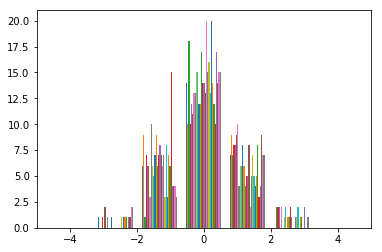

In [5]:
plt.hist(random_noise,bins=5)
plt.xlim(-5,5)

In [6]:
noised_test = (x_test + np.sign(random_noise) * eps).clip(min=0, max=1)
noised_test.shape

(10000, 28, 28)

In [7]:
x_test = x_test.reshape(-1, 1, 28, 28)
noised_test = noised_test.reshape(-1, 1, 28, 28)

In [8]:
network = DeepConvNet()

network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [9]:
def change_noise_list(x_list, eps):
    noise_list = []
    for x in x_list:
        random_noise1 = np.random.normal(loc = 0, scale = 1, size = (1, 28, 28))
        noise = (x + eps * np.sign(random_noise1)).clip(min=0, max=1)
        noise_list.append(noise)
        
    noise_list = np.array(noise_list)
    return noise_list

In [10]:
def generate_adv(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [11]:
def change_adv_list(x_list, t_list, network, eps):
    adv_list = []
    for x, t in zip(x_list, t_list):
        adv = generate_adv(x, t, network, eps)
        adv_list.append(adv.reshape(1, 28, 28))
        
    adv_list = np.array(adv_list)
    return adv_list

In [12]:
noised1_test = change_noise_list(x_test, eps)
noised1_test.shape

(10000, 1, 28, 28)

In [13]:
fgsm_test = change_adv_list(x_test, t_test, network, eps)
fgsm_test.shape

(10000, 1, 28, 28)

In [14]:
print("無加工に対する正答率：", network.accuracy(x_test, t_test))
print("ランダムノイズに対する正答率（統一したノイズ）：", network.accuracy(noised_test, t_test))
print("ランダムノイズに対する正答率（全部異なるノイズ）：", network.accuracy(noised1_test, t_test))
print("FGSMに対する正答率：", network.accuracy(fgsm_test, t_test))

無加工に対する正答率： 0.9925
ランダムノイズに対する正答率（統一したノイズ）： 0.9372
ランダムノイズに対する正答率（全部異なるノイズ）： 0.899
FGSMに対する正答率： 0.3733


左から順に無加工、ランダムノイズ（統一）、ランダムノイズ（異なる）、FGSM


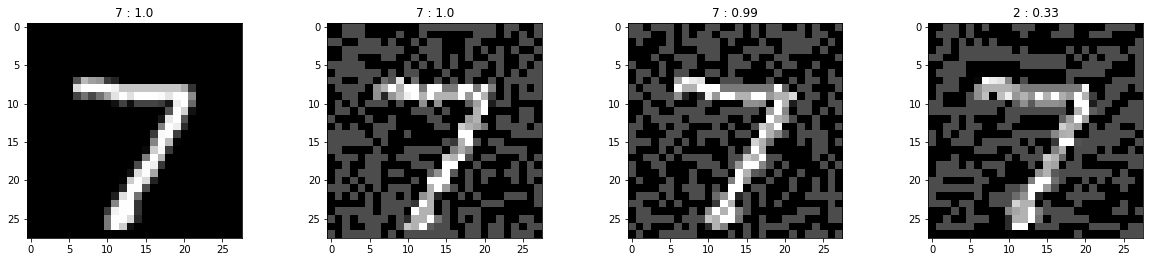

In [15]:
print("左から順に無加工、ランダムノイズ（統一）、ランダムノイズ（異なる）、FGSM")
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0.4, hspace=0.1)

for i, x in enumerate([x_test[0], noised_test[0], noised1_test[0], fgsm_test[0]]):
    x = x.reshape(1, 1, 28, 28)
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    ax.set_title(f"{pre_label} : {pre_score}")